In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import os
import shutil
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [6]:
labels = os.listdir("github_tim/tomatoleaf/tomato/train")
labels 

['Tomato___Late_blight',
 'Tomato___healthy',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite']

In [8]:
import numpy as np
src = os.listdir("github_tim/tomatoleaf/tomato/val/Tomato___Tomato_mosaic_virus/")
for i in range(np.random.randint(0,5)):
  print(i)
  print(src[i])

0
Tomato___Tomato_mosaic_virus_original_1ae794c7-287b-4a16-9cff-2fa11545eb00___PSU_CG 2102.JPG_e9b7ba5d-1f94-4bb4-97bd-77e389e678ec.JPG
1
0befa341-0db3-49f4-b4fc-beeb05854bff___PSU_CG 2338.JPG
2
Tomato___Tomato_mosaic_virus_original_0bf3eb4c-e2cd-4e72-8834-4fc045bd67ae___PSU_CG 2414.JPG_e049958b-854c-46b4-abc9-2feeebe17186.JPG
3
Tomato___Tomato_mosaic_virus_original_0fefaaee-79e4-45a6-8606-5a4ab1ea43a2___PSU_CG 2398.JPG_d95f1f1a-3def-44b3-88fb-579e4365558a.JPG


In [9]:
import cv2
image =  cv2.imread("github_tim/tomatoleaf/tomato/val/Tomato___Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG")
image.shape

(256, 256, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

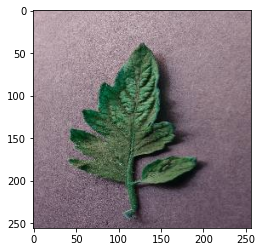

In [15]:
image = cv2.imread('github_tim/tomatoleaf/tomato/val/Tomato___Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG')
plt.imshow(image)
plt.show

In [16]:
# Now try to create the test data!
for label in os.listdir("github_tim/tomatoleaf/tomato/val"):
  path = "github_tim/tomatoleaf/tomato/val/"+ label+"/"
  src = os.listdir(path)
  for i in range(np.random.randint(0,5)):
    src_file = path + src[i]
    shutil.copy(src_file,"github_tim/out/test")

In [17]:
# Set all parameters
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [18]:
TRAIN_PATH = 'github_tim/tomatoleaf/tomato/train'
VALID_PATH = 'github_tim/tomatoleaf/tomato/val'
TEST_PATH = 'github_tim/out/test/'

In [21]:
# Augmentate the datas!
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [22]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

In [23]:
# Now flow data from directories!
train_gen = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    class_mode="categorical",
    seed=42
)

valid_gen = datagen.flow_from_directory(
    directory = VALID_PATH,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    class_mode="categorical",
    seed=42
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [26]:
# Now we create for the testing after training part

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_gen = datagen.flow_from_directory(
        "../input/tomatoleaf/tomato",
        classes=['test'],
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 0 images belonging to 1 classes.


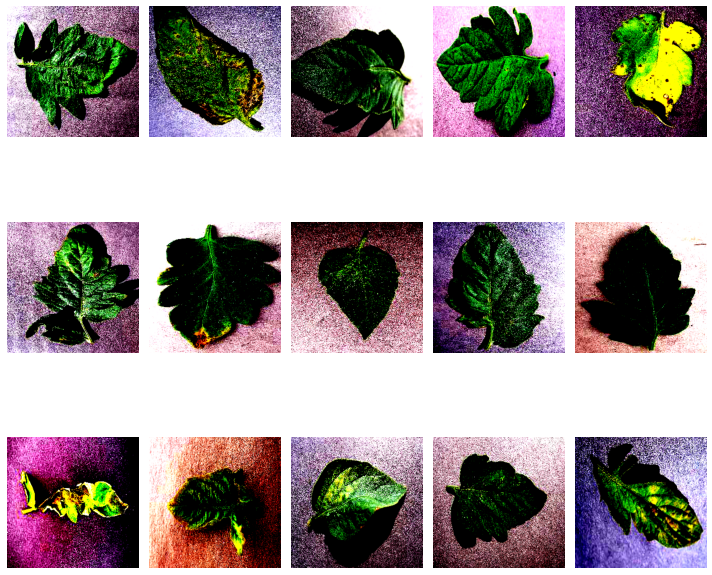

In [28]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Now build the model!
from vit_keras import vit

In [30]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(labels))

353255424/353253686 [==============================] - 8s 0us/step


In [53]:
# Use the keras API

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(labels), 'softmax')
    ],
    name = 'vision_transformer')

In [54]:
# Set the hyperparameters and callbacks

import keras.backend as K

def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [55]:
# Setup all requirements for good training!
learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy',f1])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'github_tim/out/model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nAccuracy better than target training!")
      self.model.stop_training = True

stop_callback = myCallback()

callbacks = [earlystopping, reduce_lr, checkpointer]

In [1]:
%%time
history = model.fit(x = train_gen,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_gen,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 20,
                    callbacks = callbacks)

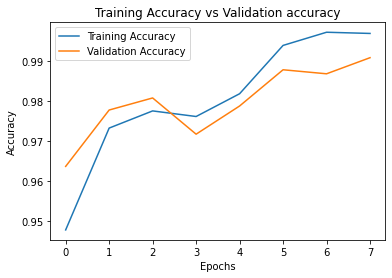

In [57]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

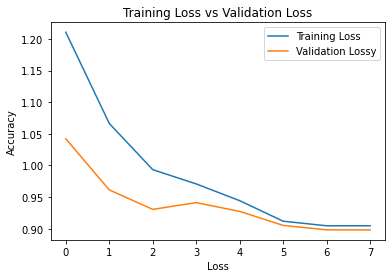

In [58]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Lossy')
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.show()